In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./..")

In [3]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch import optim
#
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm
#

from misc.plot_utils import plot_mat, imshow
from effcn.layers import FCCaps, FCCapsWOBias, Squash
from effcn.utils import count_parameters
from effcn.functions import margin_loss
from datasets import AffNIST

In [4]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

In [5]:
#!pip install einops

In [6]:
transform_train = None
transform_valid = None # converts [0,255] to [0,1] by dividing through 255

p_data = '/home/matthias/projects/EfficientCN/data'

ds_mnist_train = AffNIST(p_root=p_data, split="mnist_train", download=True, transform=transform_train, target_transform=None)
ds_mnist_valid = AffNIST(p_root=p_data, split="mnist_valid", download=True, transform=transform_valid, target_transform=None)
ds_affnist_valid = AffNIST(p_root=p_data, split="affnist_valid", download=True, transform=transform_valid, target_transform=None)

In [7]:
dl_mnist_train = torch.utils.data.DataLoader(
    ds_mnist_train, 
    batch_size=256, 
    shuffle=True,
    pin_memory=True,
    num_workers=4)
dl_mnist_valid= torch.utils.data.DataLoader(
    ds_mnist_valid, 
    batch_size=256, 
    shuffle=True, 
    pin_memory=True,
    num_workers=4)
dl_affnist_valid= torch.utils.data.DataLoader(
    ds_affnist_valid, 
    batch_size=256, 
    shuffle=True, 
    pin_memory=True,
    num_workers=4)

In [8]:
x, _ = next(iter(dl_mnist_train))
x_vis_train = x[:32]

x, _ = next(iter(dl_mnist_valid))
x_vis_mnist_valid = x[:32]

x, _ = next(iter(dl_affnist_valid))
x_vis_affnist_valid = x[:32]

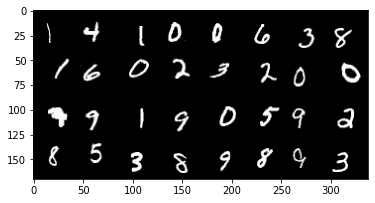

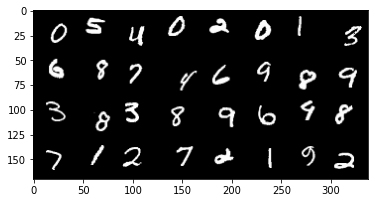

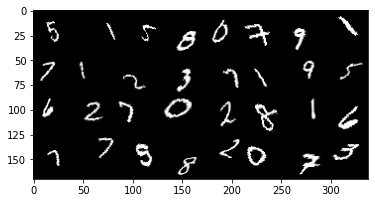

In [9]:
plt.imshow(torchvision.utils.make_grid(x_vis_train).permute(1,2,0))
plt.show()
#
plt.imshow(torchvision.utils.make_grid(x_vis_mnist_valid).permute(1,2,0))
plt.show()
#
plt.imshow(torchvision.utils.make_grid(x_vis_affnist_valid).permute(1,2,0))
plt.show()

In [10]:
class UniversalPrimeCaps(nn.Module):
    def __init__(self, n_l, n_h, d_l, d_h):
        super().__init__()
        self.n_l = n_l
        self.n_h = n_h
        self.d_l = d_l
        self.d_h = d_h
        
        self.W = torch.nn.Parameter(torch.rand(n_h, d_l, d_h), requires_grad=True)
        self.squash = Squash(eps=1e-20)
        
        torch.nn.init.kaiming_normal_(
            self.W, a=0, mode='fan_in', nonlinearity='leaky_relu')

        self.attention_scaling = np.sqrt(d_l)
    
    def forward(self, U_l):
        """
            In:  U_l
            Out: U_h
            DIMS:
                U_l  (n_l, d_l)
                U_h  (n_h, d_h)
                W    (n_h, d_l, d_h)
        """
        U_hat = torch.einsum("...ij, ...kjl -> ...ikl", U_l, self.W)
        A = torch.einsum("...ikl, ...hkl -> ...hik", U_hat, U_hat)
        A_scaled = A / self.attention_scaling
        A_sum = torch.einsum("...hij->...hj", A_scaled)
        C = torch.softmax(A_sum, dim=-1)
        U_h = torch.einsum('...ikl,...ik->...kl', U_hat, C)
        return self.squash(U_h)

In [11]:
b = 1
n_l = 2  # i
d_l = 4  # j
n_h = 3  # k
d_h = 5  # l
#
U_l = torch.rand(b, n_l, d_l)
model = UniversalPrimeCaps(n_l, n_h, d_l, d_h)
W = model.W
#
U_hat = torch.einsum("...ij, ...kjl -> ...ikl", U_l, model.W)
#A = torch.einsum("...ikl, ...hkl -> ...hik", U_hat, U_hat)
U_h = model(U_l)

In [93]:
class VisualCapsules(nn.Module):
    """
        Add Dropout ?
    """
    def __init__(self, h, w, c, patch_hw, d_out):
        super().__init__()
        self.h = h                    # img height
        self.w = w                    # img width
        self.c = c                    # img channels
        self.d_out = d_out            # embedding dim
        self.patch_hw = patch_hw      # patch size = patch_h, patch_w
        
        self.n_patches = h//patch_hw * w//patch_hw  # = #capsules
        self.n_caps = self.n_patches
        
        # make sure it adds up
        self.d_patch = patch_hw**2 * c 
        assert self.n_patches * self.d_patch == h * w * c

        self.pos_emb = nn.Parameter(
            torch.rand(1, self.n_patches, d_out),
            requires_grad=True
        )
        self.patch_emb = nn.Sequential(
            nn.Linear(self.d_patch, self.d_out),
        )
        dd = 256
        self.head = nn.Sequential(
            nn.Linear(self.d_out, dd),
            #nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(dd, dd),
            #nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(dd, dd),
            #nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(dd, self.d_out),
            Squash(eps=1e-20)
        )
        self.emb_dropout = nn.Dropout(0.1)
    def forward(self, x):
        """
            in:  x (b, c, h, w)
            out: (b, patch_hw, d)
        """
        batch_size = x.shape[0]
        x = rearrange(
            x, 'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_hw, patch_y=self.patch_hw)
        x = self.patch_emb(x)
        x = x + self.pos_emb
        x = self.emb_dropout(x)
        x = self.head(x)
        return x
    
class CapsOnly(nn.Module):
    def __init__(self, h, w, c, patch_hw, dim, n_pc, n_dc):
        super().__init__()
        self.caps_visual = VisualCapsules(h,w,c,patch_hw,dim)
        self.caps_parts = UniversalPrimeCaps(n_l=self.caps_visual.n_caps, n_h=n_pc, d_l=dim, d_h=dim)
        self.caps_digits = FCCaps(n_l=n_pc, n_h=n_dc, d_l=dim, d_h=dim)
    
    def forward(self, x):
        x = self.caps_visual(x)
        x = self.caps_parts(x)
        x = self.caps_digits(x)
        return x

class CapsOnly2L(nn.Module):
    def __init__(self, h, w, c, patch_hw, dim, n_dc):
        super().__init__()
        self.caps_visual = VisualCapsules(h,w,c,patch_hw,dim)
        self.caps_digits = UniversalPrimeCaps(n_l=self.caps_visual.n_caps, n_h=n_dc, d_l=dim, d_h=dim)
    
    def forward(self, x):
        x = self.caps_visual(x)
        x = self.caps_digits(x)
        return x

In [100]:
d = 32
patch_hw = 8
n_pc = 16
n_dc = 10

model = CapsOnly(40, 40, 1, patch_hw=patch_hw, dim=d, n_pc=n_pc, n_dc=n_dc)  # 93, 52
model = model.to(device)
print(count_parameters(model))

331520


In [101]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

In [102]:
num_epochs = 51
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_mnist_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        u_h = model.forward(x)
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=10)
        loss = margin_loss(u_h, y_one_hot)

        loss.backward()
        
        optimizer.step()
        
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item()
                 }
        )
    lr_scheduler.step()
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 5 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_mnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   mnist acc_valid: {:.3f}".format(total_correct / total))

    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_affnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   affnist acc_valid: {:.3f}".format(total_correct / total))

Train [  0/ 51]:██████████| 235/235 [00:04<00:00, 57.76it/s, loss=0.492, acc=0.229]                                                          


   mnist acc_valid: 0.217
   affnist acc_valid: 0.178


Train [  1/ 51]:██████████| 235/235 [00:04<00:00, 58.42it/s, loss=0.437, acc=0.292]                                                          
Train [  2/ 51]:██████████| 235/235 [00:04<00:00, 58.68it/s, loss=0.35, acc=0.5]                                                             
Train [  3/ 51]:██████████| 235/235 [00:04<00:00, 57.88it/s, loss=0.241, acc=0.719]                                                          
Train [  4/ 51]:██████████| 235/235 [00:03<00:00, 65.88it/s, loss=0.213, acc=0.698]                                                          
Train [  5/ 51]:██████████| 235/235 [00:03<00:00, 59.94it/s, loss=0.209, acc=0.656]                                                          


   mnist acc_valid: 0.767
   affnist acc_valid: 0.359


Train [  6/ 51]:██████████| 235/235 [00:04<00:00, 58.62it/s, loss=0.182, acc=0.75]                                                           
Train [  7/ 51]:██████████| 235/235 [00:04<00:00, 58.48it/s, loss=0.141, acc=0.844]                                                          
Train [  8/ 51]:██████████| 235/235 [00:04<00:00, 57.29it/s, loss=0.158, acc=0.812]                                                          
Train [  9/ 51]:██████████| 235/235 [00:03<00:00, 58.88it/s, loss=0.128, acc=0.865]                                                          
Train [ 10/ 51]:██████████| 235/235 [00:03<00:00, 59.08it/s, loss=0.129, acc=0.833]                                                          


   mnist acc_valid: 0.872
   affnist acc_valid: 0.431


Train [ 11/ 51]:██████████| 235/235 [00:04<00:00, 58.04it/s, loss=0.105, acc=0.885]                                                          
Train [ 12/ 51]:██████████| 235/235 [00:04<00:00, 58.42it/s, loss=0.0893, acc=0.896]                                                         
Train [ 13/ 51]:██████████| 235/235 [00:04<00:00, 58.70it/s, loss=0.0994, acc=0.885]                                                         
Train [ 14/ 51]:██████████| 235/235 [00:04<00:00, 58.04it/s, loss=0.0989, acc=0.896]                                                         
Train [ 15/ 51]:██████████| 235/235 [00:04<00:00, 57.40it/s, loss=0.101, acc=0.865]                                                          


   mnist acc_valid: 0.890
   affnist acc_valid: 0.454


Train [ 16/ 51]:██████████| 235/235 [00:03<00:00, 59.76it/s, loss=0.0891, acc=0.885]                                                         
Train [ 17/ 51]:██████████| 235/235 [00:03<00:00, 64.41it/s, loss=0.112, acc=0.865]                                                          
Train [ 18/ 51]:██████████| 235/235 [00:03<00:00, 59.89it/s, loss=0.0911, acc=0.875]                                                         
Train [ 19/ 51]:██████████| 235/235 [00:04<00:00, 57.97it/s, loss=0.0777, acc=0.885]                                                         
Train [ 20/ 51]:██████████| 235/235 [00:03<00:00, 59.53it/s, loss=0.0893, acc=0.885]                                                         


   mnist acc_valid: 0.903
   affnist acc_valid: 0.469


Train [ 21/ 51]:██████████| 235/235 [00:04<00:00, 57.05it/s, loss=0.0773, acc=0.896]                                                         
Train [ 22/ 51]:██████████| 235/235 [00:04<00:00, 57.22it/s, loss=0.0874, acc=0.875]                                                         
Train [ 23/ 51]:██████████| 235/235 [00:03<00:00, 60.55it/s, loss=0.0644, acc=0.896]                                                         
Train [ 24/ 51]:██████████| 235/235 [00:04<00:00, 57.14it/s, loss=0.0819, acc=0.906]                                                         
Train [ 25/ 51]:██████████| 235/235 [00:03<00:00, 59.43it/s, loss=0.0808, acc=0.906]                                                         


   mnist acc_valid: 0.912
   affnist acc_valid: 0.470


Train [ 26/ 51]:██████████| 235/235 [00:03<00:00, 58.90it/s, loss=0.0594, acc=0.948]                                                         
Train [ 27/ 51]:██████████| 235/235 [00:04<00:00, 58.57it/s, loss=0.0764, acc=0.896]                                                         
Train [ 28/ 51]:██████████| 235/235 [00:03<00:00, 59.85it/s, loss=0.0879, acc=0.885]                                                         
Train [ 29/ 51]:██████████| 235/235 [00:04<00:00, 57.97it/s, loss=0.0463, acc=0.938]                                                         
Train [ 30/ 51]:██████████| 235/235 [00:04<00:00, 56.14it/s, loss=0.0665, acc=0.938]                                                         


   mnist acc_valid: 0.915
   affnist acc_valid: 0.474


Train [ 31/ 51]:██████████| 235/235 [00:03<00:00, 62.71it/s, loss=0.0527, acc=0.938]                                                         
Train [ 32/ 51]:██████████| 235/235 [00:03<00:00, 71.13it/s, loss=0.0687, acc=0.906]                                                         
Train [ 33/ 51]:██████████| 235/235 [00:03<00:00, 58.78it/s, loss=0.0618, acc=0.896]                                                         
Train [ 34/ 51]:██████████| 235/235 [00:04<00:00, 57.83it/s, loss=0.0514, acc=0.938]                                                         
Train [ 35/ 51]:██████████| 235/235 [00:03<00:00, 59.24it/s, loss=0.0759, acc=0.885]                                                         


   mnist acc_valid: 0.916
   affnist acc_valid: 0.478


Train [ 36/ 51]:██████████| 235/235 [00:03<00:00, 61.34it/s, loss=0.0764, acc=0.885]                                                         
Train [ 37/ 51]:██████████| 235/235 [00:04<00:00, 57.91it/s, loss=0.0435, acc=0.958]                                                         
Train [ 38/ 51]:██████████| 235/235 [00:04<00:00, 57.50it/s, loss=0.0757, acc=0.906]                                                         
Train [ 39/ 51]:██████████| 235/235 [00:04<00:00, 58.51it/s, loss=0.0597, acc=0.885]                                                         
Train [ 40/ 51]:██████████| 235/235 [00:04<00:00, 57.93it/s, loss=0.0465, acc=0.958]                                                         


   mnist acc_valid: 0.920
   affnist acc_valid: 0.493


Train [ 41/ 51]:██████████| 235/235 [00:04<00:00, 58.70it/s, loss=0.0695, acc=0.906]                                                         
Train [ 42/ 51]:██████████| 235/235 [00:03<00:00, 59.99it/s, loss=0.0559, acc=0.927]                                                         
Train [ 43/ 51]:██████████| 235/235 [00:03<00:00, 58.85it/s, loss=0.071, acc=0.906]                                                          
Train [ 44/ 51]:██████████| 235/235 [00:03<00:00, 59.34it/s, loss=0.0469, acc=0.958]                                                         
Train [ 45/ 51]:██████████| 235/235 [00:04<00:00, 57.08it/s, loss=0.0405, acc=0.948]                                                         


   mnist acc_valid: 0.924
   affnist acc_valid: 0.497


Train [ 46/ 51]:██████████| 235/235 [00:03<00:00, 58.84it/s, loss=0.0563, acc=0.927]                                                         
Train [ 47/ 51]:██████████| 235/235 [00:04<00:00, 57.65it/s, loss=0.0396, acc=0.969]                                                         
Train [ 48/ 51]:██████████| 235/235 [00:04<00:00, 57.63it/s, loss=0.0566, acc=0.927]                                                         
Train [ 49/ 51]:██████████| 235/235 [00:03<00:00, 58.92it/s, loss=0.0772, acc=0.917]                                                         
Train [ 50/ 51]:██████████| 235/235 [00:04<00:00, 58.23it/s, loss=0.055, acc=0.948]                                                          


   mnist acc_valid: 0.924
   affnist acc_valid: 0.497


93, 57
94, 54
### Results
- pos emb
- dropout
d = 32
patch_hw = 8
n_pc = 16
n_dc = 10
nl = 256

-> 91., 51

### NEW
d = 32
patch_hw = 8
n_pc = 16
n_dc = 10

nl = 0 84, 39
nl = 1 82, 39

dh = 64
nl = 2 86, 42
nl = 3 85, 45
nl = 4 86, 45

dh = 128
nl = 2 87, 44
nl = 3 88, 46
nl = 4 89, 46

dh = 256
nl = 2 88, 43
nl = 3 91, 47
nl = 4 91, 50

dh = 512
nl = 2 90, 47
nl = 3 92, 49
nl = 4 92, 50

dh = 1024
nl = 2 90, 48
nl = 3 92, 51
nl = 4 -


### OLD
##### dh
d = 32
patch_hw = 8
n_pc = 16
n_dc = 10

dh = 512 91, 50
dh = 256 91, 50
dh = 128 89, 46

-> 256

##### patch_hw
dh = 256
d = 32
n_pc = 16
n_dc = 10

patch_hw = 4   -> 82, 41
patch_hw = 5   -> 83, 40
patch_hw = 8   -> 90, 47
patch_hw = 10   -> 93, 53
patch_hw = 20   -> 94, 49

---> 10

##### n_pc
dh = 256
d = 32
n_pc = 16
n_dc = 10
patch_hw = 10

n_pc = 4  94, 51
n_pc = 8  94, 54
n_pc = 10 94, 54
n_pc = 16 93, 54
n_pc = 32 94, 53
n_pc = 64 94, 52

##### d
dh = 256
n_dc = 10
patch_hw = 10
n_pc = 16

d = 8  83,43
d = 16 92,49
d = 32 94,52
d = 64 94,54

# Eval

In [ ]:
def imshow(img, cmap="gray", vmin=None, vmax=None):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap, vmin=None, vmax=None)
    plt.show()

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    tensor = tensor.cpu()
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    #return grid

In [ ]:
model.eval()

In [ ]:
YY = []
CC = []
UUH = []
UUHSQ = []
UUHFIN = []
UUL = []

for X, Y in dl_valid:
    X = X.to(device)
    X = model.caps_visual(X)
    U_l = model.caps_parts(X)
    U_hat, A, A_scaled, A_sum, C, U_h_fin, U_h_sq = model.caps_digits.forward_debug(U_l)
    
    UUL.append(U_l.detach().cpu().numpy())
    UUH.append(U_hat.detach().cpu().numpy())
    YY.append(Y.numpy())
    CC.append(C.detach().cpu().numpy())
    UUHSQ.append(U_h_sq.detach().cpu())
    UUHFIN.append(U_h_fin.detach().cpu())
YY = np.concatenate(YY)
CC = np.concatenate(CC)
UUHSQ = np.concatenate(UUHSQ)
UUHFIN = np.concatenate(UUHFIN)
UUH = np.concatenate(UUH)
UUL = np.concatenate(UUL)

print(YY.shape)
print(CC.shape)

print("U_l      ", U_l.shape[1:])
print("U_hat    ", U_hat.shape[1:])
print("A        ", A.shape[1:])
print("A_scaled ", A_scaled.shape[1:])
print("A_sum    ", A_sum.shape[1:])
print("C        ", C.shape[1:])
print("U_h_fin  ", U_h_fin.shape[1:])
print("U_h_sq   ", U_h_sq.shape[1:])

In [ ]:
idcs = np.where(YY == 0)
Y = YY[idcs]
C = CC[idcs]
UH = UUH[idcs]
UHS = UUHSQ[idcs]
UHF = UUHFIN[idcs]

In [ ]:
for idx in range(5):
    print("#"*100)
    y = Y[idx]
    c = C[idx]
    uhs = UHS[idx]
    uhf = UHF[idx]
    ul = UUL[idx]
    #plot_mat(ul, scale_factor=0.4, title="U_l = lower level capsules")
    plot_mat(c, scale_factor=0.4, title="C")
    #plot_mat(uhf, scale_factor=0.4, title="U_h, upper layer capsules w/o squash")
    #plot_mat(uhs, scale_factor=0.4, title="squash(U_h)")
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2))
    axes[0].bar(range(10), c.mean(axis=0))
    axes[0].set_title("C")
    axes[3].bar(range(10), np.linalg.norm(uhs, axis=1))
    axes[3].set_title("sqash(U_h)")
    axes[2].bar(range(10), np.linalg.norm(uhf, axis=1))
    axes[2].set_title("U_h without Squash")
    axes[1].bar(range(ul.shape[0]), np.linalg.norm(ul, axis=1))
    axes[1].set_title("U_l")
    plt.show()

# Positional Embeddings

In [ ]:
n_p = int(np.sqrt(model.caps_visual.n_patches))
all_pe = model.caps_visual.pos_emb.data.detach().cpu()[0]

In [ ]:
all_pe.shape

In [ ]:
pe.repeat_interleave(49).reshape((49, -1))

In [ ]:
pe

In [ ]:
fig, axes = plt.subplots(n_p, n_p, figsize=(10, 10))
for ix in range(n_p):
    for iy in range(n_p):
        ax = axes[ix][iy]
        pe = all_pe[ix * n_p + iy]
        pe = pe.repeat_interleave(49).reshape((49, -1))
        cossim = F.cosine_similarity(pe, all_pe)
        ax.imshow(cossim.reshape((7, 7)), vmin=-1, vmax=1)
plt.show()

In [ ]:
cossim.max()

In [ ]:
cossim.reshape((7, 7))

In [ ]:
pe.shape

In [ ]:
F.cosine_similarity(pe, pe)

In [ ]:
pe.view((7, 7, -1))

In [ ]:
pe.shape